In [3]:
import sqlite3 as sq
from functools import wraps
from typing import Any, Sequence, Optional
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler


DATABASE_PATH = "../data/olist.db"

def db_connection(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Permet de passer un autre chemin si besoin: sql_df(query, params, db_path="...")
        db_path = kwargs.pop("db_path", DATABASE_PATH)
        with sq.connect(db_path) as conn:
            conn.execute("PRAGMA foreign_keys = ON;")
            return func(conn, *args, **kwargs)  # commit/rollback gérés par le context manager
    return wrapper

@db_connection
def sql_df(conn: sq.Connection, query: str, params: Optional[Sequence[Any]] = None) -> pd.DataFrame:
    """SELECT → DataFrame (prend en charge les paramètres SQL via '?')."""
    return pd.read_sql_query(query, conn, params=params)


Analysons les tables contenues dans la base:

In [4]:
req1 = """
    SELECT name FROM sqlite_master WHERE type='table';
"""
sql_df(req1)

,name
0,customers
1,geoloc
2,order_items
3,order_pymts
4,order_reviews
5,orders
6,products
7,sellers
8,translation


Voyons un apercu des tables principales de notre db:

In [5]:
for table in ["customers", "orders", "order_items", "order_pymts"]:
    df = sql_df(f"SELECT * FROM {table} LIMIT 5")
    print(f"\n=== {table.upper()} ===")
    display(df.head())


=== CUSTOMERS ===


,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



=== ORDERS ===


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00



=== ORDER_ITEMS ===


,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



=== ORDER_PYMTS ===


,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Voyons s'il y a le même nombre de commandes dans la table orders et order_items:

In [6]:
print(sql_df("SELECT COUNT(*) AS n_orders FROM orders"))
print(sql_df("SELECT COUNT(DISTINCT order_id) AS n_unique_orders FROM order_items"))

   n_orders
0     99441
   n_unique_orders
0            98666


Il y a donc 775 commandes "orphelines". Vérifions que c'est bien le cas:

In [7]:
sql_df("""
       SELECT COUNT(*) as nb_commandes_orphelines 
FROM orders o
LEFT JOIN order_items i ON o.order_id = i.order_id
WHERE i.order_id IS NULL;""")

,nb_commandes_orphelines
0,775


Voyons les statuts des différentes commandes:

In [8]:
sql_df("SELECT order_status, COUNT(*) as n FROM orders GROUP BY order_status ORDER BY n DESC")

,order_status,n
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [9]:
sql_df("""
    SELECT order_status, COUNT(*) AS num
    FROM orders o
    LEFT JOIN order_items i ON o.order_id = i.order_id
    WHERE i.order_id IS NULL
    GROUP BY order_status;
""")

,order_status,num
0,canceled,164
1,created,5
2,invoiced,2
3,shipped,1
4,unavailable,603


Nous avons donc la liste de nos commandes orphelines qui sont bien annulées, indisponibles, créées, facturées et envoyées mais non livrées. Elles ne constituent donc pas une réelle experience client et ne sont pas liées à une transaction, donc nous pouvons nous en affranchir.

In [22]:
RFM_SQL = """
    WITH delivered_orders AS (
        SELECT
            o.order_id,
            c.customer_unique_id,
            o.order_purchase_timestamp,
            o.order_delivered_customer_date
        FROM orders o
        JOIN customers c
        ON c.customer_id = o.customer_id
        WHERE o.order_status = 'delivered'
    ),
    valid_orders AS (
        SELECT DISTINCT i.order_id
        FROM order_items i
    ),
    delivered_with_items AS (
        SELECT
            d.order_id,
            d.customer_unique_id,
            d.order_purchase_timestamp,
            d.order_delivered_customer_date
        FROM delivered_orders d
        INNER JOIN valid_orders v USING(order_id)
    ),
    order_amounts AS (
        SELECT
            op.order_id,
            SUM(op.payment_value) AS order_amount
        FROM order_pymts op
        GROUP BY op.order_id
    ),
    reviews_by_order AS (
        SELECT
            r.order_id,
            AVG(r.review_score) AS review_score
        FROM order_reviews r
        GROUP BY r.order_id
    ),
    ref AS (
        SELECT DATETIME(MAX(order_purchase_timestamp), '+1 day') AS ref_ts
        FROM delivered_with_items
    ),
    customer_agg AS (
        SELECT
            d.customer_unique_id,
            MAX(d.order_purchase_timestamp)                       AS last_purchase_ts,
            COUNT(DISTINCT d.order_id)                            AS frequency,
            SUM(COALESCE(oa.order_amount, 0))                     AS monetary,
            AVG(rbo.review_score)                                 AS avg_review_score,
            AVG(
                CASE
                WHEN d.order_delivered_customer_date IS NOT NULL
                THEN JULIANDAY(d.order_delivered_customer_date) - JULIANDAY(d.order_purchase_timestamp)
                END
            ) AS avg_delivery_delay
        FROM delivered_with_items d
        LEFT JOIN order_amounts    oa  ON oa.order_id  = d.order_id
        LEFT JOIN reviews_by_order rbo ON rbo.order_id = d.order_id
        GROUP BY d.customer_unique_id
    )
    SELECT
        ca.customer_unique_id AS customer_id,
        ca.last_purchase_ts,
        ca.frequency,
        ca.monetary,
        CAST(ROUND(JULIANDAY(r.ref_ts) - JULIANDAY(ca.last_purchase_ts)) AS INTEGER) AS recency_days,
        ca.avg_review_score,
        ca.avg_delivery_delay
    FROM customer_agg ca
    CROSS JOIN ref r
    ORDER BY ca.customer_unique_id;
       """

rfm = sql_df(RFM_SQL)
rfm.head()

,customer_id,last_purchase_ts,frequency,monetary,recency_days,avg_review_score,avg_delivery_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90,112,5.0,6.411227
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19,115,4.0,3.285590
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22,538,3.0,25.731759
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62,322,4.0,20.037083
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89,289,5.0,13.141134


In [23]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         93358 non-null  object 
 1   last_purchase_ts    93358 non-null  object 
 2   frequency           93358 non-null  int64  
 3   monetary            93358 non-null  float64
 4   recency_days        93358 non-null  int64  
 5   avg_review_score    92755 non-null  float64
 6   avg_delivery_delay  93350 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 5.0+ MB


In [24]:
rfm.describe()

,frequency,monetary,recency_days,avg_review_score,avg_delivery_delay
count,93358.000000,93358.000000,93358.000000,92755.000000,93350.000000
mean,1.033420,165.197003,238.519527,4.153643,12.567474
std,0.209097,226.314012,152.596929,1.280158,9.546171
min,1.000000,0.000000,1.000000,1.000000,0.533414
25%,1.000000,63.052500,115.000000,4.000000,6.788001
50%,1.000000,107.780000,220.000000,5.000000,10.234248
75%,1.000000,182.557500,347.000000,5.000000,15.717986
max,15.000000,13664.080000,714.000000,5.000000,209.628611


In [25]:
rfm[rfm['frequency'] > 1 ]

,customer_id,last_purchase_ts,frequency,monetary,recency_days,avg_review_score,avg_delivery_delay
104,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,2,354.37,228,5.000000,6.851105
243,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,2,123.25,88,4.000000,17.631603
305,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,2,126.20,527,4.000000,6.240885
404,011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,2,214.90,134,3.500000,13.443559
419,011b4adcd54683b480c4d841250a987f,2018-02-15 11:40:57,2,236.30,196,4.500000,12.827980
...,...,...,...,...,...,...,...
92991,ff03923ad1eb9e32304deb7f9b2a45c9,2018-05-26 11:51:22,2,247.06,96,3.000000,7.507795
93085,ff44401d0d8f5b9c54a47374eb48c1b8,2017-05-19 21:20:54,2,68.00,468,3.000000,12.343796
93187,ff8892f7c26aa0446da53d01b18df463,2017-11-26 23:25:43,2,330.14,277,3.250000,36.582616
93205,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-09-14 14:24:04,3,139.60,350,4.333333,17.060050


In [26]:
rfm.isna().sum()

customer_id             0
last_purchase_ts        0
frequency               0
monetary                0
recency_days            0
avg_review_score      603
avg_delivery_delay      8
dtype: int64

In [27]:
rfm["frequency"].value_counts().head(10)

frequency
1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: count, dtype: int64

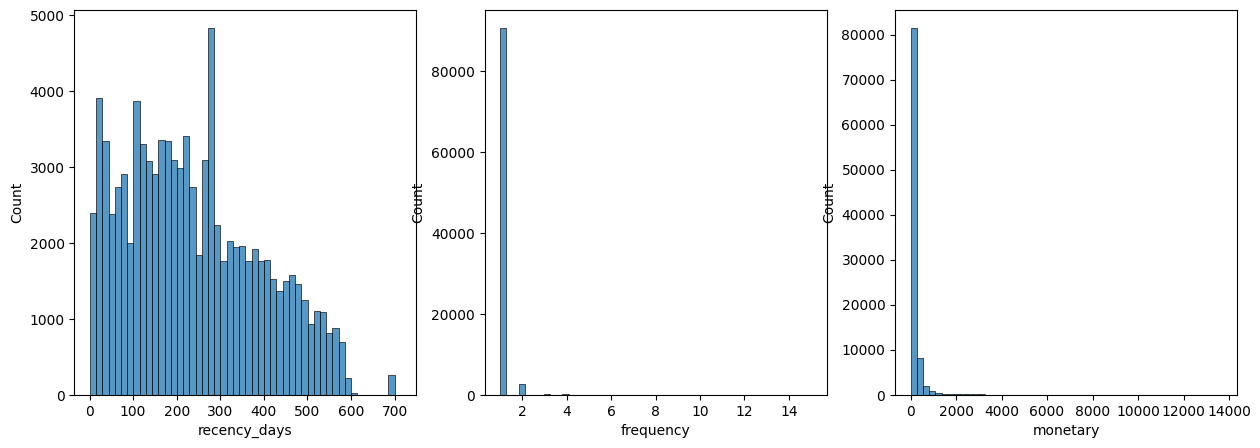

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.histplot(rfm["recency_days"], bins=50, ax=axes[0])
sns.histplot(rfm["frequency"], bins=50, ax=axes[1])
sns.histplot(rfm["monetary"], bins=50, ax=axes[2])
plt.show()

### Distribution de la fréquence (nombre de commandes par client)

On observe que la base clients est extrêmement déséquilibrée :  
- Environ **94 % des clients n’ont qu’une seule commande** (mono-acheteurs).  
- Seuls **~3 % des clients ont plus d’une commande** (multi-acheteurs), avec un maximum à 15 commandes.  

D’un point de vue marketing, il serait pertinent de traiter séparément ces deux populations :  
- les mono-acheteurs représentent la masse mais avec une valeur vie client faible,  
- les multi-acheteurs sont rares mais concentrent la valeur et devraient être ciblés en priorité.  

Dans le cadre de ce projet, et conformément aux consignes, **nous conservons tous les clients dans un seul dataset**.  
Pour rendre les variables exploitables en clustering, nous appliquerons une **standardisation** afin de rendre les échelles comparables.  
Une transformation logarithmique sur `frequency` et `monetary` est une option possible pour réduire l’influence des valeurs extrêmes, mais elle n’est pas indispensable et pourra être testée à titre de comparaison.

D’autres variables (ticket moyen, diversité produits…) pourraient être explorées dans une version ultérieure, notamment pour analyser plus finement les multi-acheteurs.
Cependant, dans le cadre de ce projet, nous nous concentrons sur un jeu de variables simples, disponibles pour l’ensemble des clients, afin de garantir une segmentation robuste et directement exploitable par le marketing.

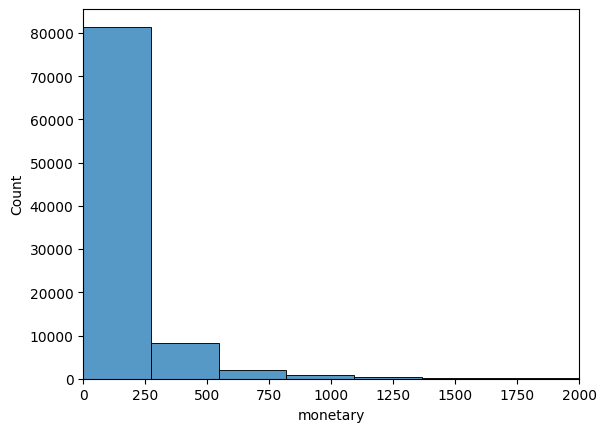

In [29]:
sns.histplot(rfm["monetary"], bins=50)
plt.xlim(0, 2000)
plt.show()

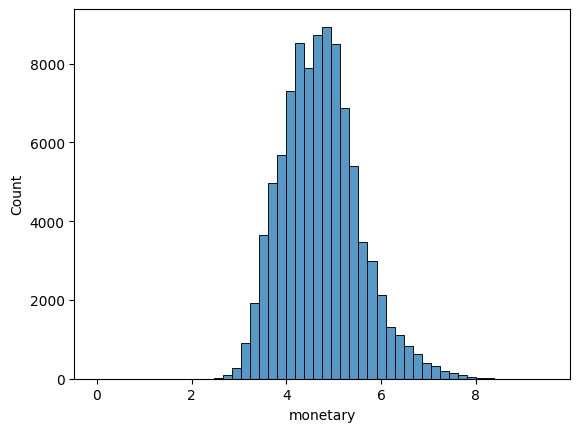

In [30]:
# A tester? à envisager si les resultats de clustering sont trop "skewed" 
sns.histplot(np.log1p(rfm["monetary"]), bins=50)
plt.show()

<Axes: xlabel='monetary'>

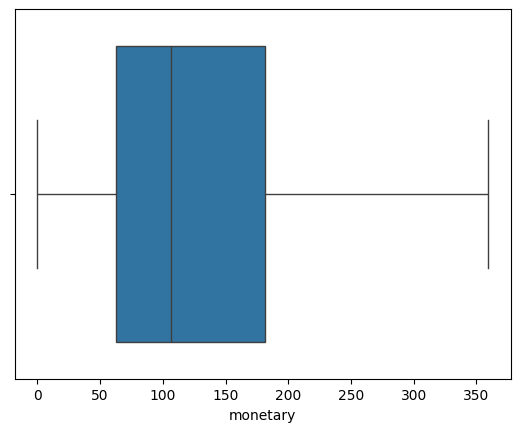

In [20]:
sns.boxplot(x=rfm["monetary"], showfliers=False)

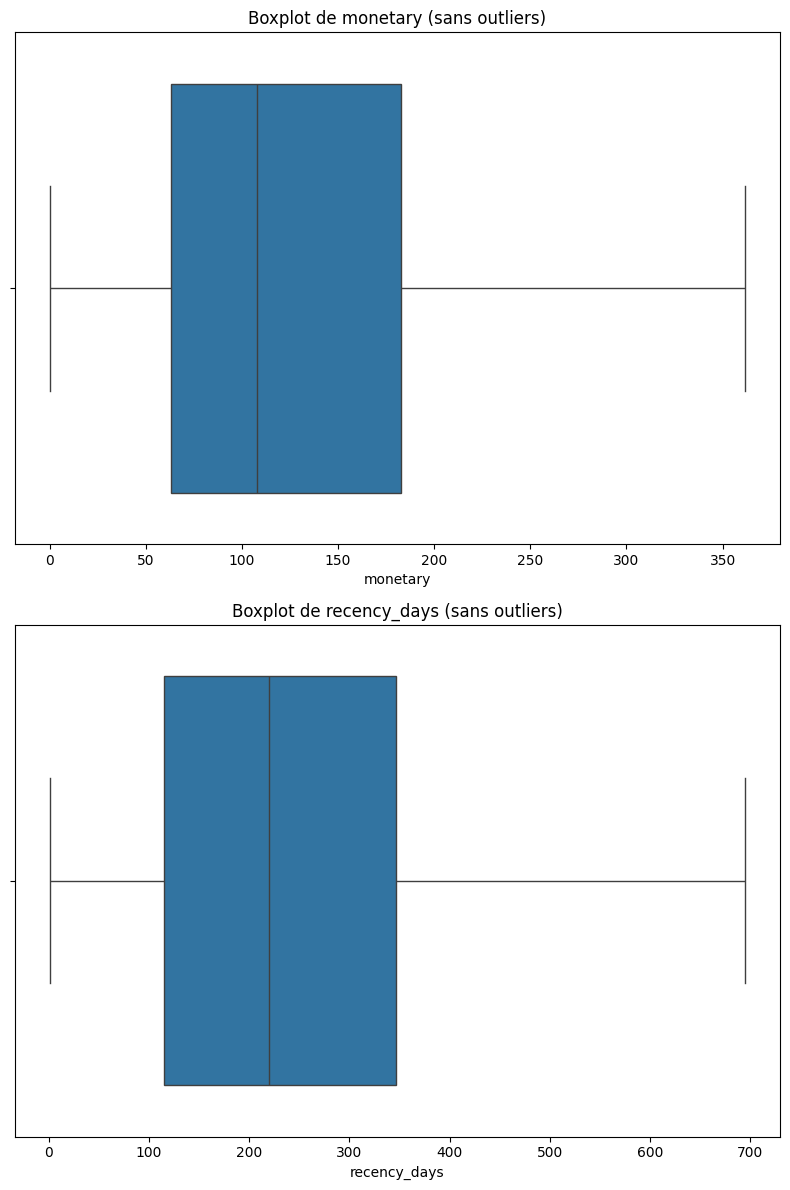

In [101]:
variables_rfm = ["monetary", "recency_days"]

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

for i, var in enumerate(variables_rfm):
    sns.boxplot(x=rfm[var], showfliers=False, ax=axes[i])
    axes[i].set_title(f"Boxplot de {var} (sans outliers)")
    axes[i].set_xlabel(var)

plt.tight_layout()
plt.show()

In [21]:
rfm.head()

,customer_id,period,last_purchase_ts,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-31,2018-05-10 10:56:27,21,1,141.90,5.0,6.411227
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-06-30,2018-05-10 10:56:27,51,1,141.90,5.0,6.411227
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-07-31,2018-05-10 10:56:27,82,1,141.90,5.0,6.411227
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-08-31,2018-05-10 10:56:27,113,1,141.90,5.0,6.411227
4,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-31,2018-05-07 11:11:27,24,1,27.19,4.0,3.285590


In [103]:
# Index = customer_id
rfm = rfm.set_index("customer_id")

# Drop date
rfm = rfm.drop(columns=["last_purchase_ts"])

# Imputer NaN
rfm["avg_review_score"] = rfm["avg_review_score"].fillna(rfm["avg_review_score"].mean())
rfm["avg_delivery_delay"] = rfm["avg_delivery_delay"].fillna(rfm["avg_delivery_delay"].mean())

# Features prêtes
features = ["recency_days", "frequency", "monetary", "avg_review_score", "avg_delivery_delay"]

X = rfm[features]
X.to_csv("olist_customers_features.csv")
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=rfm.index)
X_scaled_df.to_csv("olist_customers_features_scaled.csv")


### Choix de l’outil pour le calcul des features

- Les **agrégations lourdes** et jointures entre plusieurs tables (RFM, moyenne des reviews, délai moyen de livraison) ont été réalisées directement en SQL.  
  → C’est plus efficace, plus rapide, et cela évite de manipuler un volume de données trop important dans pandas.  

- Les **transformations légères et spécifiques au machine learning** (standardisation, transformation logarithmique, création éventuelle de ratios simples) ont été réalisées en Python/pandas.  
  → Cela permet de garder une grande souplesse pour les tests et l’expérimentation côté notebook.  

Ce choix de répartition SQL / Python permet d’optimiser les performances tout en gardant la lisibilité du workflow analytique.

In [31]:
RFM_SQL_DATE = """
    WITH delivered_orders AS (
    SELECT
        o.order_id,
        c.customer_unique_id,
        o.order_purchase_timestamp,
        o.order_delivered_customer_date
    FROM orders o
    JOIN customers c ON c.customer_id = o.customer_id
    WHERE o.order_status = 'delivered'
),
valid_orders AS (
    SELECT DISTINCT i.order_id
    FROM order_items i
),
delivered_with_items AS (
    SELECT
        d.order_id,
        d.customer_unique_id,
        d.order_purchase_timestamp,
        d.order_delivered_customer_date
    FROM delivered_orders d
    INNER JOIN valid_orders v USING(order_id)
),
order_amounts AS (
    SELECT
        op.order_id,
        SUM(op.payment_value) AS order_amount
    FROM order_pymts op
    GROUP BY op.order_id
),
reviews_by_order AS (
    SELECT
        r.order_id,
        AVG(r.review_score) AS review_score
    FROM order_reviews r
    GROUP BY r.order_id
),
base AS (
    SELECT
        d.customer_unique_id,
        d.order_id,
        DATETIME(d.order_purchase_timestamp) AS ts,
        COALESCE(oa.order_amount, 0) AS amount,
        rbo.review_score,
        CASE
            WHEN d.order_delivered_customer_date IS NOT NULL
            THEN JULIANDAY(d.order_delivered_customer_date) - JULIANDAY(d.order_purchase_timestamp)
        END AS delivery_delay
    FROM delivered_with_items d
    LEFT JOIN order_amounts    oa  ON oa.order_id  = d.order_id
    LEFT JOIN reviews_by_order rbo ON rbo.order_id = d.order_id
),
bounds AS (
    SELECT DATE(MIN(ts), 'start of month') AS first_month_start,
           DATE(MAX(ts), 'start of month') AS last_month_start
    FROM base
),
months(month_start) AS (
    SELECT first_month_start FROM bounds
    UNION ALL
    SELECT DATE(month_start, '+1 month') FROM months, bounds
    WHERE month_start < DATE(last_month_start, '+0 month')
),
month_ends AS (
    SELECT DATE(month_start, 'start of month', '+1 month', '-1 day') AS period
    FROM months
),
cum AS (
    SELECT
        b.*,
        COUNT(*)  OVER (PARTITION BY b.customer_unique_id ORDER BY b.ts
                        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_orders,
        SUM(b.amount) OVER (PARTITION BY b.customer_unique_id ORDER BY b.ts
                            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_amount,
        AVG(b.review_score) OVER (PARTITION BY b.customer_unique_id ORDER BY b.ts
                                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_review,
        AVG(b.delivery_delay) OVER (PARTITION BY b.customer_unique_id ORDER BY b.ts
                                    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_delay
    FROM base b
),
last_order_by_month AS (
    SELECT
        c.customer_unique_id,
        me.period,
        MAX(c.ts) AS last_purchase_ts
    FROM cum c
    JOIN month_ends me
      ON c.ts <= DATETIME(me.period, '+1 day')  -- inclure tout le jour
    GROUP BY c.customer_unique_id, me.period
)
SELECT
    lom.customer_unique_id AS customer_id,
    lom.period,
    lom.last_purchase_ts,  -- <- correction ici
    CAST(ROUND(JULIANDAY(lom.period) - JULIANDAY(lom.last_purchase_ts)) AS INTEGER) AS recency_days, -- <- et ici
    lo.cum_orders   AS frequency,
    lo.cum_amount   AS monetary,
    lo.cum_review   AS avg_review_score,
    lo.cum_delay    AS avg_delivery_delay
FROM last_order_by_month lom
JOIN cum lo
  ON lo.customer_unique_id = lom.customer_unique_id
 AND lo.ts = lom.last_purchase_ts
ORDER BY customer_id, period;
       """

rfm_date = sql_df(RFM_SQL_DATE)
rfm_date.head()

,customer_id,period,last_purchase_ts,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-31,2018-05-10 10:56:27,21,1,141.90,5.0,6.411227
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-06-30,2018-05-10 10:56:27,51,1,141.90,5.0,6.411227
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-07-31,2018-05-10 10:56:27,82,1,141.90,5.0,6.411227
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-08-31,2018-05-10 10:56:27,113,1,141.90,5.0,6.411227
4,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-31,2018-05-07 11:11:27,24,1,27.19,4.0,3.285590


In [32]:
rfm_date.to_csv("olist_customers_features_with_period.csv")